### Modul import

In [1]:
# Common
import pandas as pd
import numpy as np

# Text processing
import re
from bs4 import BeautifulSoup
import nltk

# Visualization modules
import matplotlib.pyplot as plt

# Model modules
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile
from gensim.test.utils import datapath
from gensim.models.ldamulticore import LdaMulticore

from gensim.models import phrases, word2vec

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None


C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pyodbc
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(r'DRIVER={SQL Server};SERVER=LIPHT-VM-01;DATABASE=Akademikernes_MSCRM_addition;Trusted_Connection=yes')
conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
engine = create_engine(conn_str)

### Load Functions

In [3]:
from lipht_lda import df_lda_preprocessing, lda_preprocess_string, df_lda_features, get_lda_topics, lda_predict_df, lda_predict_string, document_to_bow, df_lda_features

# Import Data

In [4]:
# df_raw = pd.read_pickle('data/AKA_rawdata.pkl')
# df_import = df_raw.copy(deep=True)

In [5]:
%%time
# df_import = pd.read_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')
# df_import = pd.read_pickle('data/AKA_rawdata_with_language.pkl')

Wall time: 0 ns


In [6]:
%%time
# df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadTotalMessageCount']>1) & (df_B['ThreadHasInteraction']>=1) & (df_B['ThreadResponsibleDepartmentTeam']=='Udbetalingsteam') & (df_B['pred_label']=='Danish')]
# df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadResponsibleDepartmentTeam'].str.contains('Udbetalingsteam')==True) & (df_B['pred_label']=='Danish')]
# print(df_B.shape)

Wall time: 0 ns


#### Setup Analysis Parameters

In [7]:
dataset = 'Udbetalingsteam'
initiatedby = 'Initiatedby_AKA'
n_gram = 3
sample_size= 10000
no_words= 5000
no_below= 10 # filter out tokens that appear in less than 15 documents
random_state=1
research_scope = 'Udbetalingteam'
num_topics = 7

In [8]:
df_import = pd.read_pickle('data/{}/{}.pkl'.format(initiatedby,dataset))

In [9]:
# Create dataset for method B
# Process 1st MemberMessage, then
# Concatenate with Subject
df = df_import.copy(deep=True)
df.head()

,ThreadID,ThreadSubject,FirstMessage,FirstMemberMessage,ThreadInitiatedBy,ThreadClass,InDiagnosticScope,ThreadMessageID,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,...,text_Exclamationmarks,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,language_prediction,language_probability,language_id,language
22,119851D3-AAEC-E611-AC9F-005056AD2D14,Vigtig viden om dit gratis medlemskab da du sn...,Du bliver snart 30 år og så gælder der andre r...,\nHej\n \nJeg ønsker forsat at være fritaget ...,AKA,AKA to Member to AKA,1,1B9851D3-AAEC-E611-AC9F-005056AD2D14,Forsikring,Udbetalingsteam,...,0,"[gælder_der, og, i, for_kontingentfritagelse, ...","[gælder_der, for_kontingentfritagelse, regler,...","[gælder_der, for_kontingentfritagelse, regler,...","[gælder_d, for_kontingentfritag, regl, dine_mu...","[(78, 1), (258, 1), (284, 1), (365, 1)]","[0.92553055, 0, Danish]",0.925531,0,Danish
23,2ED0B527-AF2E-E711-AC9F-005056AD2D14,Du kan søge om feriedagpenge,"Du har optjent feriedagpenge, som du kan søge ...",Hej\nI brevet stå at jeg har optjent 22 dage m...,AKA,AKA to Member to AKA,1,38D0B527-AF2E-E711-AC9F-005056AD2D14,Forsikring,Udbetalingsteam,...,0,"[og, optjent, i, mange, om_dem, til, du, søge,...","[optjent, om_dem, søge, feriedagpenge_du, dage...","[optjent, om_dem, søge, feriedagpenge_du, dage...","[optjent, om_dem, søg, feriedagpenge_du, dag, ...","[(31, 1), (78, 1), (126, 1), (156, 1), (365, 1...","[0.94680625, 0, Danish]",0.946806,0,Danish
50,389A6222-EFD1-E611-B361-005056AD2D14,Tak for din ansøgning om dagpenge,None,Kære A-kasse\nLigesom jeg sad og skulle udfyld...,AKA,AKA to Member to AKA,1,CD725C28-EFD1-E611-B361-005056AD2D14,Forsikring,Udbetalingsteam,...,0,[none],[none],[none],[non],"[(31, 1), (59, 1), (60, 1), (69, 1), (84, 1), ...","[0.9690974, 0, Danish]",0.969097,0,Danish
77,D25E6449-D31D-E711-AC9F-005056AD2D14,Du kan søge om feriedagpenge,"Du har optjent feriedagpenge, som du kan søge ...",Er dette relevant i min nuværende situation?,AKA,AKA to Member to AKA,1,DC5E6449-D31D-E711-AC9F-005056AD2D14,Forsikring,Udbetalingsteam,...,0,"[og, optjent, i, mange, om_dem, til, du, søge,...","[optjent, om_dem, søge, feriedagpenge_du, dage...","[optjent, om_dem, søge, feriedagpenge_du, dage...","[optjent, om_dem, søg, feriedagpenge_du, dag, ...",[],"[0.63060194, 0, Danish]",0.630602,0,Danish
137,48EDE43A-4491-E711-BE8E-005056AD2D14,Velkommen i Akademikernes A-kasse,Vi er glade for at byde dig velkommen i Akadem...,Jeg har meldt mig ledig på jobnet samt udfyldt...,AKA,AKA to Member to AKA,1,54EDE43A-4491-E711-BE8E-005056AD2D14,Forsikring,Udbetalingsteam,...,0,"[er, og_hvad, du_skal, gøre, og, dette_brev, i...","[og_hvad, du_skal, dette_brev, det_er, hvad_du...","[og_hvad, du_skal, dette_brev, det_er, hvad_du...","[og_hvad, du_skal, dette_brev, det_, hvad_du, ...","[(40, 1), (59, 1), (71, 1), (219, 1), (324, 1)...","[0.95890415, 0, Danish]",0.958904,0,Danish


In [10]:
df.shape

(661, 26)

In [11]:
%%time
df_lda_preprocessing(df,'FirstMessage',n_gram)

Wall time: 4.2 s


In [12]:
df.isnull().sum()

ThreadID                            0
ThreadSubject                       0
FirstMessage                       53
FirstMemberMessage                  0
ThreadInitiatedBy                   0
ThreadClass                         0
InDiagnosticScope                   0
ThreadMessageID                     0
ThreadResponsibleDepartment         0
ThreadResponsibleDepartmentTeam     0
text                                0
text_CharCount                      0
text_LessThan5000                   0
text_WordCount                      0
text_Questionmarks                  0
text_1Question                      0
text_Exclamationmarks               0
tokenized_text                      0
stopwords_removed                   0
lemmatized_text                     0
stemmed_text                        0
bow                                 0
language_prediction                 0
language_probability                0
language_id                         0
language                            0
dtype: int64

In [13]:
print(df.shape)

(661, 26)


In [14]:
df.to_pickle('data/{}/{}.pkl'.format(initiatedby,dataset))

## Analyze Requests
Messages are either
- Incoming (from members) or
- Outgoing (from aka)
All messeages have
- subject_field and
- message_field

In the following we will analyze the different splits of data, with regards to the above:
- Incoming_subject
- Incoming_message
- Outgoing_subject
- Outgoing_message

### Request Analysis: Udbetaling

#### Load the data

In [15]:
%%time
# Load the data, and print rows, columns
df_scope = pd.read_pickle('data/{}/{}.pkl'.format(initiatedby,dataset))

Wall time: 37 ms


In [16]:
if sample_size>df_scope.shape[0]:
    sample_size = df_scope.shape[0]
print(df_scope.shape, sample_size)

(661, 26) 661


In [17]:
data_scope_name = initiatedby+'_'+research_scope +'_topics-'+ str(num_topics) +'_Sample-'+str(sample_size) +'_WordCount-'+str(no_words) +'_RandomState-'+str(random_state)+'_dataset-'+ dataset
print(data_scope_name)

Initiatedby_AKA_Udbetalingteam_topics-7_Sample-661_WordCount-5000_RandomState-1_dataset-Udbetalingsteam


### Vectorize words

#### Create dictionary and top words

##### Parameters:	
- **no_below** (int, optional) – Keep tokens which are contained in at least no_below documents.
- **no_above** (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n** (int, optional) – Keep only the first keep_n most frequent tokens.
- **keep_tokens** (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

In [18]:
%%time
# Create dictionary with words from df_scope (the total dataset)
dictionary = Dictionary(documents=df_scope.stemmed_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 3171 words.
Wall time: 80.8 ms


In [19]:
%%time
dictionary.filter_extremes(no_below=no_below, keep_n=no_words)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 1021 words.
Wall time: 5 ms


In [20]:
%%time
#Make a BoW for every Besked
document_to_bow(df_scope, dictionary)

Wall time: 55 ms


#### Create Sample of Scope

In [21]:
scope_lda_sample = df_scope.sample(sample_size, random_state=random_state)
scope_lda_sample.shape

(661, 26)

In [22]:
scope_lda_sample.columns.values

array(['ThreadID', 'ThreadSubject', 'FirstMessage', 'FirstMemberMessage',
       'ThreadInitiatedBy', 'ThreadClass', 'InDiagnosticScope',
       'ThreadMessageID', 'ThreadResponsibleDepartment',
       'ThreadResponsibleDepartmentTeam', 'text', 'text_CharCount',
       'text_LessThan5000', 'text_WordCount', 'text_Questionmarks',
       'text_1Question', 'text_Exclamationmarks', 'tokenized_text',
       'stopwords_removed', 'lemmatized_text', 'stemmed_text', 'bow',
       'language_prediction', 'language_probability', 'language_id',
       'language'], dtype=object)

In [23]:
scope_lda_sample[['ThreadID','ThreadMessageID','ThreadSubject','FirstMemberMessage','text','tokenized_text','stopwords_removed','lemmatized_text','stemmed_text']].head()

,ThreadID,ThreadMessageID,ThreadSubject,FirstMemberMessage,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
6807,53E1482B-88FF-E611-AC9F-005056AD2D14,5DE1482B-88FF-E611-AC9F-005056AD2D14,Du skal sende en sidste og afsluttende 6-måned...,Jeg er bedt om at indsende 6-månederserklæring...,"da du er fyldt 65, skal du sende en sidste og ...","[for_at, sende, du_er, en, du_sende, en_endeli...","[for_at, sende, du_er, du_sende, en_endelig_op...","[for_at, sende, du_er, du_sende, en_endelig_op...","[for_at, send, du_, du_s, en_endelig_opgør, af..."
15347,58DA49E0-F4A1-E711-BE8E-005056AD2D14,62DA49E0-F4A1-E711-BE8E-005056AD2D14,Vejledning om din sidste tid som ledig,Kære aka\nhvornår er min sidste barselsdag? Mi...,i den sidste tid som ledig skal du ikke opfyld...,"[vi_dig_nærmere, dig_nærmere_om, det, ikke_opf...","[vi_dig_nærmere, dig_nærmere_om, ikke_opfylde,...","[vi_dig_nærmere, dig_nærmere_om, ikke_opfylde,...","[vi_dig_nærm, dig_nærmere_om, ikke_opfyld, i_d..."
1076,4DADB1A3-80FD-E611-AC9F-005056AD2D14,57ADB1A3-80FD-E611-AC9F-005056AD2D14,Du kan nu søge om udbetaling af skattefri præmie,Hermed min ansøgning om udbetaling af skattefr...,du kan snart søge om udbetaling af sktilefri p...,"[udbetaling_af_sktilefri, en, udbetaling_af, s...","[udbetaling_af_sktilefri, udbetaling_af, sktil...","[udbetaling_af_sktilefri, udbetaling_af, sktil...","[udbetaling_af_sktilefri, udbetaling_af, sktil..."
2623,943C81E6-954A-E711-BE8E-005056AD2D14,9E3C81E6-954A-E711-BE8E-005056AD2D14,Du er blevet ledig - hvad nu?,Kære AAk\nHermed min erklæring om fravær.\nMed...,"vi har fået besked fra jobcenteret, om at du h...","[booke, en, forhold_til_de, til_de, at_du_har,...","[booke, forhold_til_de, til_de, at_du_har, bes...","[booke, forhold_til_de, til_de, at_du_har, bes...","[book, forhold_til_d, til_d, at_du_har, besked..."
5380,C73D65D8-FCB7-E711-B45B-005056AD2D14,D23D65D8-FCB7-E711-B45B-005056AD2D14,Du er blevet ledig - hvad nu?,Jeg er vendt tilbage efter en sygemelding (4. ...,"vi har fået besked fra jobcenteret, om at du h...","[booke, en, forhold_til_de, til_de, at_du_har,...","[booke, forhold_til_de, til_de, at_du_har, bes...","[booke, forhold_til_de, til_de, at_du_har, bes...","[book, forhold_til_d, til_d, at_du_har, besked..."


### Find optimal number of topics for LDA
#### K-means Elbow method

#### Create Topwords
Create a list of topwords from the entire dataframe

#### Tf-idf and document similarity

I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the clean_content list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by request. This is transformed into a request-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a request but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the request.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the request a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the request it probably cares little meanining - rule of thumb (verify this)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the request to be considered. Here I pass 0.2; the term must be in at least 20% of the request. 

TEST THIS
I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [24]:
%%time
top_words = [v for v in dictionary.values()]
top_words = list(set(top_words))
df_scope['OnlyTopWords'] = list(map(lambda doc: [word for word in doc if word in top_words], df_scope['stemmed_text']))

Wall time: 361 ms


In [25]:
print("No of top words: {} ".format(len(top_words)))

No of top words: 1021 


In [26]:
from lipht_lda import remove_not_topwords, ListToString

In [27]:
# %%time
top_words, _ = remove_not_topwords(scope_lda_sample, df_scope)

In [28]:
# # Create dictionary with words from df_scope (the total dataset) or scope_lda_sample (the sample size)
# dictionary = Dictionary(documents=df_scope.stemmed_text.values)
# #Make a BoW for every Besked
# document_to_bow(df_scope)

In [29]:
# LDA preprocessing
print("Found {} words.".format(len(dictionary.values())))

Found 1021 words.


In [30]:
%%time
scope_lda_sample['clean_content'] = scope_lda_sample['OnlyTopWords'].apply(ListToString)

Wall time: 3.43 ms


In [31]:
%%time
tfidf_wordvector = TfidfVectorizer(
                analyzer='word', 
                max_df=0.8, 
                min_df=5, 
#                 stop_words=stopwords.words('danish'),
#                 ngram_range=(1,3)
                ) 

#fit the tfidf_wordvector to clean_content
tfidf_wordvector_maxtrix = tfidf_wordvector.fit_transform(scope_lda_sample.clean_content)
print(tfidf_wordvector_maxtrix.shape)

(661, 500)
Wall time: 52 ms


dist is defined as 1 - the cosine similarity of each request. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each request and the other request in the corpus (each clean_content among the total clean_content). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more clean_content.

In [32]:
tfidf_wordvector_2d = tfidf_wordvector_maxtrix.todense()

In [33]:
top_range = 50
increments = 1

In [34]:
%%time
distortions = []
K = range(1,top_range,increments)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(tfidf_wordvector_2d)
    kmeanModel.fit(tfidf_wordvector_2d)
    distortions.append(sum(np.min(cdist(tfidf_wordvector_2d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_wordvector_2d.shape[0])

Wall time: 32.8 s


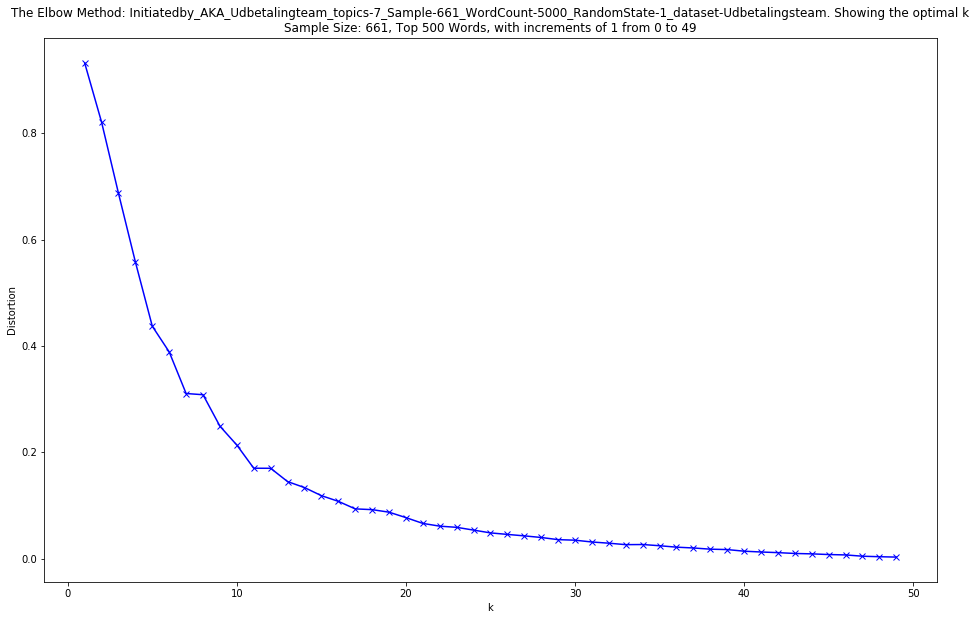

In [35]:
# Plot the elbow
title_elbow = 'The Elbow Method: {4}. Showing the optimal k\nSample Size: {0}, Top {1} Words, with increments of {2} from 0 to {3}'.format(sample_size, len(top_words), increments, top_range-1, data_scope_name)
info_text = research_scope +'_topics-'+ str(num_topics) +'_Sample-'+str(sample_size) +'_WordCount-'+str(no_words) +'_RandomState-'+str(random_state)
filename = '{}_The Elbow Method_{}'.format(research_scope, info_text)
plt.figure(figsize=(16, 10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title(title_elbow)
plt.savefig(fname='data/{}/{}.png'.format(initiatedby,filename),transparent=True)
plt.show()

## LDA Model Training
Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents)

In [36]:
# We want to maximize the probability of the corpus in the training set.
corpus = scope_lda_sample.bow

In [37]:
print(('LDA Model based on {3} dataset.\n\tSample Size: {0},\n\tTop {1} Words,\n\tNo of Topics {2}'.format(sample_size, len(dictionary.values()), num_topics, data_scope_name)))

LDA Model based on Initiatedby_AKA_Udbetalingteam_topics-7_Sample-661_WordCount-5000_RandomState-1_dataset-Udbetalingsteam dataset.
	Sample Size: 661,
	Top 1021 Words,
	No of Topics 7


In [38]:
%%time
#A multicore approach to decrease training time
# https://radimrehurek.com/gensim/corpora/mmcorpus.html
# ram_corpus = get_tmpfile("corpus_scope.mm")
# MmCorpus.serialize(ram_corpus, corpus)
# mm = MmCorpus(ram_corpus)
LDAmodel_scope = LdaMulticore(corpus=corpus,#mm,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=5000,
                        passes=50,
                        alpha='asymmetric',
                        random_state=random_state)

Wall time: 27.6 s


In [39]:
dictionary.save('data/model/{0}_dictionary.pkl'.format(research_scope))#data_scope_name))

In [40]:
LDAmodel_scope.save('data/model/{0}'.format(research_scope))#data_scope_name))

In [41]:
LDAmodel_scope = LdaMulticore.load('data/model/{0}'.format(research_scope))#data_scope_name))

#### Feature vector

In [42]:
%%time
df_lda_features(LDAmodel_scope, scope_lda_sample)

Wall time: 181 ms


#### Topic distributions and let's see some words that come with the topics

In [43]:
RequestTopicDistribution = scope_lda_sample['lda_features'].mean()

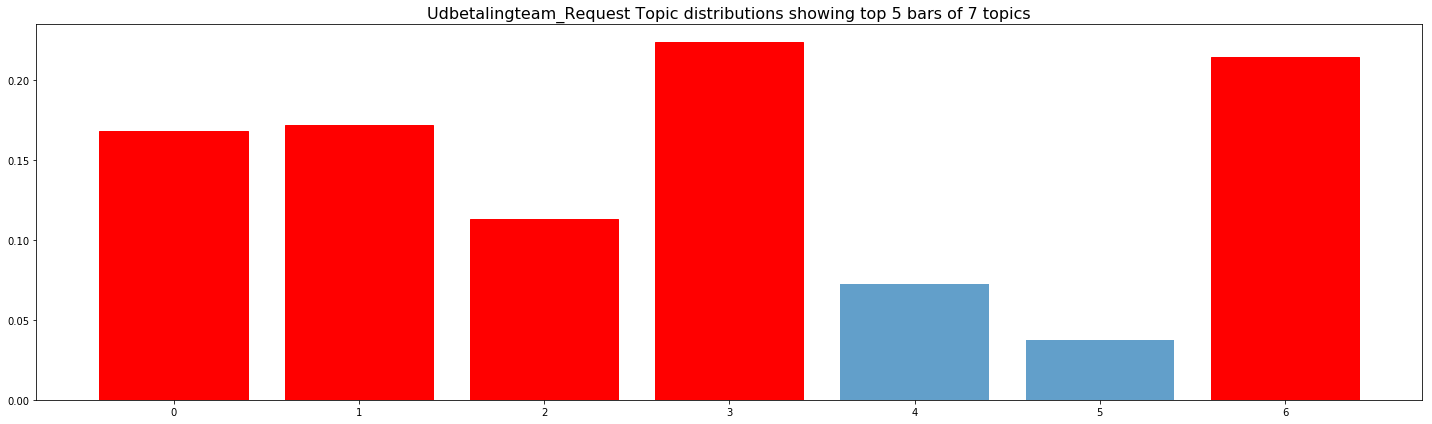

In [63]:
fig, ax1 = plt.subplots(1,1,figsize=(20,6))
nr_top_bars = 5
title_dist ='{}_Request Topic distributions showing top {} bars of {} topics'.format(research_scope, nr_top_bars, num_topics)
ax1.set_title(title_dist, fontsize=16)

for ax, distribution, color in zip([ax1], [RequestTopicDistribution], ['r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)

fig.tight_layout(h_pad=3.)
fig.savefig(fname='data/{}/{}'.format(initiatedby,title_dist),transparent=True)

#### Inspect topics and words

In [45]:
from lipht_lda import get_topics_and_probability, get_lda_topics

In [46]:
df_topics = get_topics_and_probability(scope_lda_sample, LDAmodel_scope, num_topics, 5)
df_topics

,Probability,TopWords,Topic
0,0.168311,"0.020*""brev"" + 0.019*""led"" + 0.017*""som_led"" +...",0.0
1,0.171502,"0.019*""mul"" + 0.017*""måned"" + 0.017*""sende_"" +...",1.0
2,0.112893,"0.012*""vi_har"" + 0.012*""at_du"" + 0.012*""du_"" +...",2.0
3,0.223502,"0.037*""søg"" + 0.019*""læs_nærm"" + 0.019*""læs_næ...",3.0
4,0.072577,"0.012*""mød"" + 0.011*""du_skal"" + 0.010*""at_du"" ...",4.0
5,0.037082,"0.006*""period"" + 0.005*""joblog"" + 0.005*""søg"" ...",5.0
6,0.214134,"0.021*""ansøgning"" + 0.021*""din_ansøgning_om"" +...",6.0


In [62]:
df_topics.to_sql(name='topics_{}_{}'.format(dataset,initiatedby),con=engine , schema='input', if_exists='replace', index=False)

In [48]:
get_lda_topics(scope_lda_sample, LDAmodel_scope, num_topics,20)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,brev,mul,vi_har,søg,mød,period,ansøgning
1,led,måned,at_du,læs_nærm,du_skal,joblog,din_ansøgning_om
2,som_led,sende_,du_,nærmere_i,at_du,søg,ansøgning_om
3,i_d,send,besked,læs_nærmere_i,mul,kontak,din_ansøgning
4,non,bed,har_få,som_du,ret,dag,vi_har
5,dette_brev,du_bed,fået,hvordan_du,meld,en_period,på_din
6,i_dette_brev,snarest,besked_fra,nærm,deltag,om_ug,om_feriedagpeng
7,i_det,måneder_snarest_mu,har_fået_besked,læs,til_at,ugen,feriedagpenge__og
8,for_at,snarest_mu,fået_besked_fra,brev,kl_,vi_ik,uge
9,dagpeng,bedes_s,fået_besked,du_har,kl,når_vi,vi_har_behandl


#### Name the topics

In [49]:
lda_topic_names = {
    0:'Ferie og feriepenge',
    1:'Sendt oplysninger til AKA',
    2:'Ansættelseskontrakt eller frigørelse',
    3:'Spørgsmål om dagpenge',
    4:'Ansøgning om befordring',
    5:'Ansættelse',
    6:'Ledighed',
    7:'Adgang',
    8:'Noget med tid*',
    9:'Dagpenge mellem jul og nytår',
    11:'Fejl ved dagpenge',
    12:'Spørgsmål til blanket',
    14:'Ydelseskort',
    15:'Pension og Efterløn',
    16:'Dagpenge/Supplerende',
    17:'Spørgsmål til udfyldelse',
    19:'Spørgsmål om beskæftigelse'
}

### Test the model

In [50]:
pd.options.display.max_colwidth = 200

In [51]:
# document = scope_lda_sample.sample(1) # From sample
document = df_scope.sample(1) # From population
doc_id = document['ThreadMessageID']
unseen_document = document['FirstMemberMessage']
print(doc_id, unseen_document)

9982    3690F1EF-2C4A-E711-BE8E-005056AD2D14
Name: ThreadMessageID, dtype: object 9982    Hej AKA\nHer kommer min sidste 6 måneders erklæring. Det er helt vemodigt :-(\nVenlig hilsen\nVibeke Galsbo\n 
Name: FirstMemberMessage, dtype: object


In [52]:
# Test function and prediction
print(lda_predict_string(unseen_document, LDAmodel_scope, dictionary))#,lda_topic_names))

(0.6310952, 0, '0.020*"brev" + 0.019*"led" + 0.017*"som_led" + 0.017*"i_d" + 0.013*"non"')


In [53]:
bow_vector = dictionary.doc2bow(lda_preprocess_string(unseen_document))
for index, score in sorted(LDAmodel_scope[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, LDAmodel_scope.print_topic(index, 5)))

# index, score = sorted(LDAmodel_scope[bow_vector], key=lambda tup: -1*tup[1])[0]
# print("Score: {}\t Topic: {}".format(score, LDAmodel_scope.print_topic(index, 5)))

Score: 0.6310951709747314	 Topic: 0.020*"brev" + 0.019*"led" + 0.017*"som_led" + 0.017*"i_d" + 0.013*"non"
Score: 0.09513731300830841	 Topic: 0.019*"mul" + 0.017*"måned" + 0.017*"sende_" + 0.016*"send" + 0.015*"bed"
Score: 0.07465893775224686	 Topic: 0.012*"vi_har" + 0.012*"at_du" + 0.012*"du_" + 0.011*"besked" + 0.011*"har_få"
Score: 0.061435021460056305	 Topic: 0.037*"søg" + 0.019*"læs_nærm" + 0.019*"læs_nærmere_i" + 0.019*"nærmere_i" + 0.019*"som_du"
Score: 0.052190762013196945	 Topic: 0.012*"mød" + 0.011*"du_skal" + 0.010*"at_du" + 0.008*"mul" + 0.008*"ret"
Score: 0.04536464810371399	 Topic: 0.006*"period" + 0.005*"joblog" + 0.005*"søg" + 0.005*"kontak" + 0.005*"dag"
Score: 0.04011816158890724	 Topic: 0.021*"ansøgning" + 0.021*"din_ansøgning_om" + 0.021*"ansøgning_om" + 0.021*"din_ansøgning" + 0.021*"vi_har"


### Predict topics on data
Per every row in the dataset

In [54]:
%%time
lda_predict_df(df_scope, LDAmodel_scope, dictionary)#, lda_topic_names)

Wall time: 223 ms


#### Save the data with prediction

In [58]:
print(dataset,initiatedby)

Udbetalingsteam Initiatedby_AKA


In [56]:
df_scope.to_pickle('data/{}_{}_with_prediction.pkl'.format(dataset,initiatedby))

In [61]:
df_scope_sql = df_scope[['ThreadID','ThreadMessageID','text', 'pred_probability', 'pred_index']]#, 'pred_label']]
df_scope_sql.to_sql(name='{}_{}'.format(dataset,initiatedby),con=engine , schema='input', if_exists='replace', index=False)

### Load topic and predictions to SQL Server

In [ ]:
# import pyodbc
# from sqlalchemy import create_engine
# import urllib

# params = urllib.parse.quote_plus(r'DRIVER={SQL Server};SERVER=LIPHT-VM-01;DATABASE=Akademikernes_MSCRM_addition;Trusted_Connection=yes')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
# engine = create_engine(conn_str)

In [ ]:
%%time
# df_raw = pd.read_pickle('data/AKA_rawdata.pkl')

In [ ]:
# from lipht_lda import df_lda_preprocessing

In [ ]:
%%time
# df_lda_preprocessing(df_raw, 'FirstMemberMessage')

In [ ]:
# df_raw.columns

In [ ]:
# df_raw.to_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')

In [ ]:
# df_raw[df_raw['pred_label']=='English']['text']

In [ ]:
# df_raw_with_language = df_raw[['ThreadID','ThreadMessageID','ThreadMessageText','text','pred_label','pred_probability']]

In [ ]:
df_raw_with_language.head()

In [ ]:
# df_raw_with_language.to_csv('lang_pred.csv')

In [ ]:
# con = "mssql+pyodbc:///?odbc_connect={}".format(urllib.parse.quote_plus("DRIVER=ODBC Driver 13 for SQL Server;SERVER={0};PORT=1433;DATABASE={1};UID={2};PWD={3};TDS_Version=8.0;".format(server, db, user, password)))

In [ ]:
# test = pd.DataFrame({'test':[1,2,3]}) #'te','te','te'

In [ ]:
# test.to_sql(name='Test',con=engine , schema='input', if_exists='replace', index=False)

In [ ]:
# df_raw.to_pickle('data/AKA_rawdata_with_language.pkl')

In [ ]:
# df_raw.columns